# Exercise 5: Lasso Regression on the Franke function  with resampling (Score 10 points))


In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os
from common import *
import pandas as pd
#from mpl_toolkits.mplot3d import Axes3D
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split

print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

%matplotlib inline 

Root directory: /home/arefrode/uio/fys-stk4155/projects/FYS-STK4155-Prj1_report/code


# 1.5
Start off by defining the data

In [23]:
np.random.seed(SEED_VALUE)
maxdegree = 12
degree = 9 # Chosen as the optimal degree from the bias-variance tentative
n = 10000
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
X = create_X(x,y, n = degree)
z = FrankeFunction(x, y) + 0.2*np.random.normal(0, size = n)

We want to essentially repeat the previous two exercises, as such, this exercise will follow in the footsteps of exercise 4. The difference is that the sci-kit learn implementation of Lasso regression is used. 

In [24]:
nbf_lambdas = 20
lambdas = np.logspace(-4, 1, nbf_lambdas)
z_train_lasso = pd.DataFrame()
z_hat_train_lasso = pd.DataFrame()
z_test_lasso = pd.DataFrame()
z_hat_test_lasso = pd.DataFrame()

MSE_test = np.zeros(nbf_lambdas)
MSE_train = np.zeros(nbf_lambdas)

/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.58010305534089, tolerance: 0.16952649222351013
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.55266383707715, tolerance: 0.16952649222351013
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.10742550751027, tolerance: 0.16952649222351013
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. Y

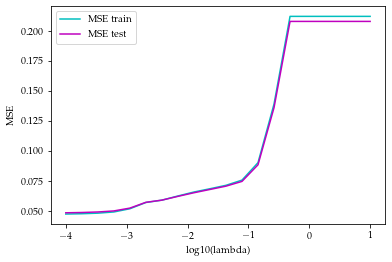

In [25]:
X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

for i in range(len(lambdas)):
    clf = lm.Lasso(lambdas[i])
    clf.fit(X_train_scaled, z_train)

    z_pred = clf.predict(X_test_scaled)
    z_fit = clf.predict(X_train_scaled)

    MSE_test[i] = np.mean( np.mean((z_test - z_pred)**2) )
    MSE_train[i] = np.mean( np.mean((z_train - z_fit)**2) )

plt.figure()
plt.plot(np.log10(lambdas), MSE_train, 'c', label = "MSE train")
plt.plot(np.log10(lambdas), MSE_test, 'm', label = 'MSE test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()


Fitting the model for the different values of $\lambda$

In [26]:
# Preparing data and training the model
X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False, random_state=SEED_VALUE)

for lmb in lambdas:
    # Fitting the linear model
    model = lm.Lasso(lmb, fit_intercept=False)
    model.fit(X_train, z_train)

    # Predicting values using the trained model
    z_hat_train = model.predict(X_train)
    z_hat_test = model.predict(X_test)

    # Filling up the dataframes
    z_train_lasso[lmb] = z_train.flatten()
    z_hat_train_lasso[lmb] = z_hat_train.flatten()
    z_test_lasso[lmb] = z_test.flatten()
    z_hat_test_lasso[lmb] = z_hat_test.flatten()

# Calculate the MSE for all lambda values
mse_scores_train = ((z_train_lasso - z_hat_train_lasso) ** 2).mean()
mse_scores_test = ((z_test_lasso - z_hat_test_lasso) ** 2).mean()
# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_lasso - z_hat_train_lasso) ** 2).sum() / ((z_train_lasso - z_train_lasso.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_lasso - z_hat_test_lasso) ** 2).sum() / ((z_test_lasso - z_test_lasso.mean())**2).sum()  



/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.86696075119937, tolerance: 0.37641101088929585
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.8286797087087, tolerance: 0.37641101088929585
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.939160541255035, tolerance: 0.37641101088929585
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. Yo

# Bootstrap
Performing the same bootstrap analysis as in Exercise 4, that is, for each lambda, loop over each degree whereas for each degree, bootstrapping is performed to generate a set of different predicted values.

In [27]:
nlambdas = 10
n_bootstraps = 100
maxdegree = 12
lambdas = np.logspace(-4, 1, nlambdas)
polydegree = np.arange(maxdegree)

for lmb in lambdas:
    MSE_test = np.zeros(maxdegree)
    MSE_train = np.zeros(maxdegree)
    bias = np.zeros(maxdegree)
    variance = np.zeros(maxdegree)

    for degree in tqdm(range(maxdegree), desc = f"Looping through polynomials up to {maxdegree} degrees with {n_bootstraps} bootstraps: "):
        model = lm.Lasso(lmb)
        X = create_X(x, y, n=degree)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

        z_test_ = np.reshape(z_test, newshape=(z_test.shape[0],1))
        z_train_ = np.reshape(z_train, newshape=(z_train.shape[0],1))

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        z_pred = np.empty((z_test.shape[0], n_bootstraps))
        z_fit = np.empty((z_train.shape[0], n_bootstraps))

        # Bootstrapping
        for i in range(n_bootstraps):
            x_, z_ = resample(X_train, z_train)
            clf = model.fit(x_, z_)
            z_pred[:, i] = clf.predict(X_test_scaled)
            z_fit[:, i] = clf.predict(X_train_scaled)

        MSE_test[degree] = np.mean( np.mean((z_test_ - z_pred)**2, axis=1, keepdims=True) )
        MSE_train[degree] = np.mean( np.mean((z_train_ - z_fit)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True))

    plt.figure()
    plt.plot(polydegree, MSE_test,"m", label='MSE\_test')
    plt.plot(polydegree, MSE_train,"c", label='MSE\_train')

    plt.plot(polydegree, bias,"g--", label='bias')
    plt.plot(polydegree, variance,"r--", label='Variance')

    plt.title(f"Bias-Variance for log10(lambda) = {np.log10(lmb)}")
    plt.xlabel("Model complexity / Polynomial Degree")
    plt.ylabel("Prediction Error")

    plt.grid(True)
    plt.legend()
    plt.show()


Looping through polynomials up to 12 degrees with 100 bootstraps:   0%|          | 0/12 [00:00<?, ?it/s]


TypeError: train_test_split() got an unexpected keyword argument 'test_split'